In [ ]:
# !pip install --user annoy

In [105]:
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
from tqdm.notebook import tqdm
from glob import glob
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

In [ ]:
# Create DB

In [102]:
img_dir = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects"
db_file_path = os.path.join(os.getcwd(), "pollen_db.ann")
indx_class_filename = db_file_path.replace(".ann", "_legend.json")

In [28]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [29]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

In [53]:
def extract_features(img_path: str, model):
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

In [107]:
def save_class_to_indices(class_to_indices: dict, filename: str):
    with open(filename, 'w') as f:
        json.dump(class_to_indices, f)

def load_class_to_indices(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [31]:
known_classes = os.listdir(OBJECTS_ROOT)

In [92]:
total_samples = 0
class_to_indices = {c: [] for c in known_classes}
f = 2048  # Length of item vector that will be indexed
t = AnnoyIndex(f, 'euclidean')
for c in tqdm(known_classes):
    images = glob(os.path.join(img_dir, c, "*.png"))
    print(f"{len(images)} samples in the class {c}")
    
    for idx, img_path in enumerate(tqdm(images)):
        features = extract_features(img_path, model)
        class_to_indices[c].append(total_samples)
        t.add_item(total_samples, features)
        total_samples += 1

print(f"Total samples: {total_samples}")
t.build(10) # 10 trees
t.save(db_file_path)
save_class_to_indices(class_to_indices, indx_class_filename)
print(f"DB with {t.get_n_items()} items saved in {db_file_path}")

  0%|          | 0/9 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 1390
DB with 1390 items saved in /home/jovyan/git/Pollen-Analyzer/Database/pollen_db.ann


In [ ]:
# Load DB

In [112]:
u = AnnoyIndex(f, 'euclidean')
u.load(db_file_path) # super fast, will just mmap the file

True

In [96]:
u.get_n_items()

1390

In [97]:
i = 0
j = 10
k = 1000
print(f"Distance between {i} and {j} = {u.get_distance(i, j)}")
print(f"Distance between {i} and {k} = {u.get_distance(i, k)}")

Distance between 0 and 10 = 8.78620719909668
Distance between 0 and 1000 = 8.550573348999023


In [98]:
len(u.get_item_vector(0))

2048

In [99]:
# DB visualisation 

In [109]:
loaded_class_to_indices = load_class_to_indices(indx_class_filename)

Quercus: 90
Tilia: 114
Corylus: 141
Acer: 319
Populus tremula: 201
Betula: 206
Alnus: 25
Pinus: 67
Salix: 227


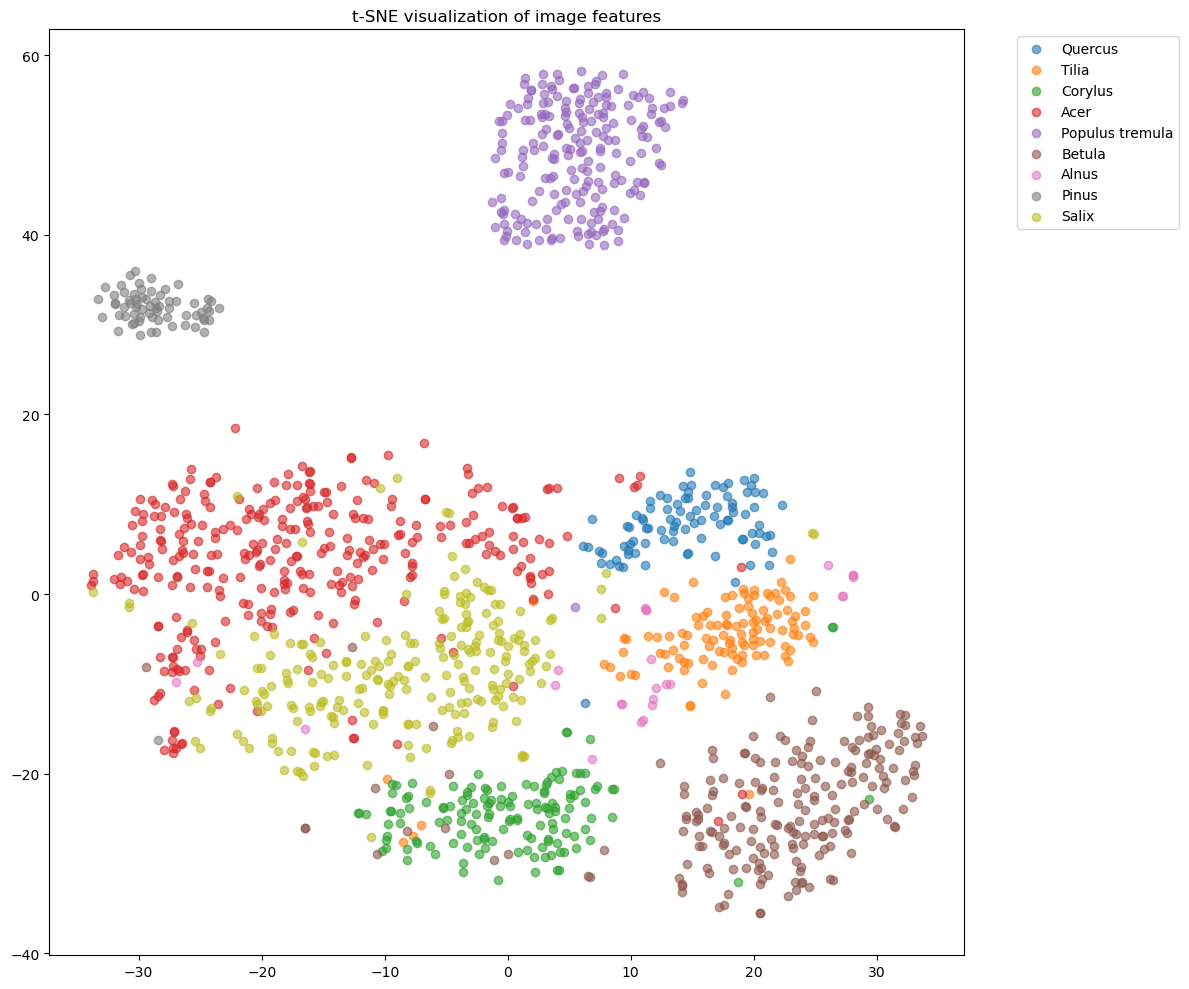

In [111]:
vectors = np.array(list(u.get_item_vector(i) for i in range(u.get_n_items())))

labels = [""] * vectors.size
for class_name, indices in loaded_class_to_indices.items():
    for index in indices:
        labels[index] = class_name
    print(f"{class_name}: {len(indices)}")

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)
color_map = {class_name: get_random_color() for class_name in class_to_indices.keys()}

plt.figure(figsize=(12, 10))
for class_name, indices in class_to_indices.items():
    mask = np.isin(range(len(vectors)), indices)
    plt.scatter(vectors_2d[mask, 0], vectors_2d[mask, 1], 
                label=class_name, alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE visualization of image features")
plt.tight_layout()
plt.show()